In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from salishsea_tools import (tidetools, geo_tools, viz_tools)
import numpy.ma as ma
import pandas as pd
import datetime
import pytz
import os
%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [3]:
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [4]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [5]:
f = pd.read_excel('/ocean/eolson/MEOPAR/obs/PSFCitSci/All_Yrs_Nutrients_2018-01-31_EOEdit.xlsx', 
                  sheetname =1, header=3)
f.keys()

Index(['Crew', 'Date (dd/mm/yyyy)', 'Time (Local)', 'Latitude', 'Longitude',
       'Station', 'Depth', 'NO3+NO', 'PO4', 'Si', 'Comments'],
      dtype='object')

In [6]:
f.shape

(1683, 11)

In [7]:
f = f.dropna(subset=['Date (dd/mm/yyyy)', 'Time (Local)', 'Latitude', 'Longitude', 
                     'Depth', 'NO3+NO', 'Si'])

In [8]:
f.shape

(1362, 11)

In [9]:
f[:5]

,Crew,Date (dd/mm/yyyy),Time (Local),Latitude,Longitude,Station,Depth,NO3+NO,PO4,Si,Comments
0,Baynes Sound,2017-03-02,13:28:00,49° 36.500,124° 52.000,BS-1,0,17.925,1.373,54.9077,NaN
2,Baynes Sound,2017-03-09,13:46:00,49° 36.500,124° 52.000,BS-1,0,11.749,1.073,20.361,NaN
3,Baynes Sound,2017-03-09,13:46:00,49° 36.500,124° 52.000,BS-1,20,6.408,0.648,55.1414,NaN
4,Baynes Sound,2017-03-20,12:35:00,49° 36.500,124° 52.000,BS-1,0,13.014,1.193,55.9846,NaN
5,Baynes Sound,2017-03-20,12:35:00,49° 36.500,124° 52.000,BS-1,20,14.407,1.234,50.9256,NaN


In [10]:
local = pytz.timezone ("America/Los_Angeles")

In [11]:
import datetime

In [12]:
datetimes = np.array([])
for index in f.index:
    dt = datetime.datetime.combine(pd.to_datetime(pd.Timestamp(f['Date (dd/mm/yyyy)'][index])), 
                          f['Time (Local)'][index])
    datetimes = np.append(datetimes, dt)

In [13]:
datetimes.shape

(1362,)

In [14]:
f = f.assign(datetime = datetimes)

In [15]:
f.shape

(1362, 12)

In [16]:
f.Crew.unique()

array(['Baynes Sound', 'Cowichan Bay', 'Campbell River', 'Galiano Island',
       'Irvines/Sechelt', 'Lund', 'Ladysmith', 'Malaspina Strait',
       'Nanaimo/Qualicum', 'Powell River', 'Steveston'], dtype=object)

In [17]:
list_of_lons = np.array([])
list_of_lats = np.array([])
list_of_datetimes = np.array([])
list_of_cs_ni = np.array([])
list_of_cs_si = np.array([])
list_of_model_ni = np.array([])
list_of_model_si = np.array([])
list_of_depths = np.array([])
cb_lons = np.array([])
cb_lats = np.array([])
cb_datetimes = np.array([])
cb_cs_ni = np.array([])
cb_cs_si = np.array([])
cb_model_ni = np.array([])
cb_model_si = np.array([])
cb_depths = np.array([])
for n in f.index:
    decLat = float(f.Latitude[n][:2]) + float(f['Latitude'][n][4:])/60
    decLon = (float(f.Longitude[n][:3]) + float(f['Longitude'][n][5:])/60) * -1
    Yind, Xind = geo_tools.find_closest_model_point(decLon, decLat, 
                                                    X, Y, land_mask = bathy.mask)
    if f['Depth'][n] == 0:
        depth = 0
    elif f['Depth'][n] == 20:
        depth = 18
    if mesh.variables['tmask'][0,depth,Yind, Xind] == 1:
        date = local.localize(f['datetime'][n], is_dst=True).astimezone(pytz.utc)
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute + 30) / 60
            ni_val = ((1-delta)*(nuts.variables['nitrate'][before.hour, depth, Yind, Xind] ) + 
                       (delta)*(nuts2.variables['nitrate'][after.hour, depth, Yind, Xind] ))
            si_val = ((1-delta)*(nuts.variables['silicon'][before.hour, depth, Yind, Xind] ) + 
                       (delta)*(nuts2.variables['silicon'][after.hour, depth, Yind, Xind] ))
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date.minute) / 60
            ni_val = (delta*(nuts.variables['nitrate'][before.hour, depth, Yind, Xind] ) + 
                       (1- delta)*(nuts2.variables['nitrate'][after.hour, depth, Yind, Xind] ))
            si_val = (delta*(nuts.variables['silicon'][before.hour, depth, Yind, Xind] ) + 
                       (1- delta)*(nuts2.variables['silicon'][after.hour, depth, Yind, Xind] ))

        list_of_lons = np.append(list_of_lons, decLon)
        list_of_lats = np.append(list_of_lats, decLat)
        list_of_datetimes = np.append(list_of_datetimes, date)
        if f['NO3+NO'][n] == '<0':
            list_of_cs_ni = np.append(list_of_cs_ni, 0)
        else:
            list_of_cs_ni = np.append(list_of_cs_ni, float(f['NO3+NO'][n]))
        if f['Si'][n] == '<0':
            list_of_cs_si = np.append(list_of_cs_si, 0)
        else:
            list_of_cs_si = np.append(list_of_cs_si, float(f['Si'][n]))
        list_of_model_ni = np.append(list_of_model_ni, ni_val)
        list_of_model_si = np.append(list_of_model_si, si_val)
        list_of_depths = np.append(list_of_depths, depth)
        if f.Crew[n] == 'Cowichan Bay':
            cb_lons = np.append(cb_lons, decLon)
            cb_lats = np.append(cb_lats, decLat)
            cb_depths = np.append(cb_depths, depth)
            cb_datetimes = np.append(cb_datetimes, date)
            if f['NO3+NO'][n] == '<0':
                cb_cs_ni = np.append(cb_cs_ni, 0)
            else:
                cb_cs_ni = np.append(cb_cs_ni, float(f['NO3+NO'][n]))
            if f['Si'][n] == '<0':
                cb_cs_ni = np.append(cb_cs_si, 0)
            else:
                cb_cs_si = np.append(cb_cs_si, float(f['Si'][n]))
            cb_model_ni = np.append(cb_model_ni, ni_val)
            cb_model_si = np.append(cb_model_si, si_val)

In [18]:
list_of_lats.shape

(1362,)

In [19]:
list_of_model_ni.shape

(1362,)

In [20]:
cb_cs_ni.shape

(219,)

In [21]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 12

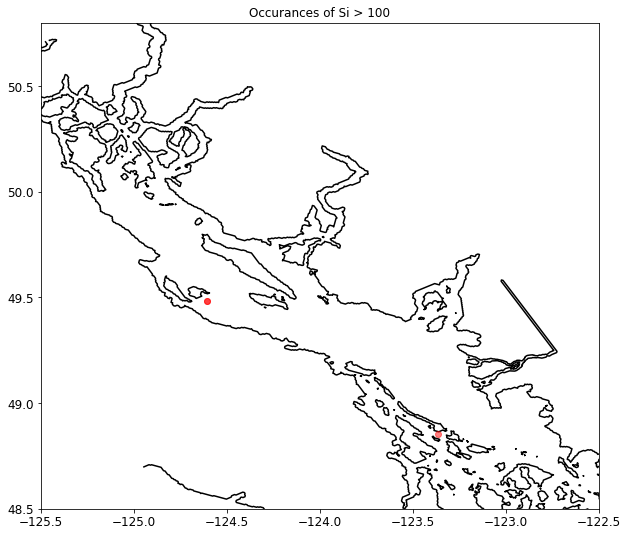

In [46]:
fig, ax = plt.subplots(figsize = (10,10))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(list_of_lons[list_of_cs_si > 100], list_of_lats[list_of_cs_si > 100], 'ro', alpha = 0.5)
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48.5, 50.8)
ax.set_title('Occurances of Si > 100')
ax.set_xlim(-125.5, -122.5);

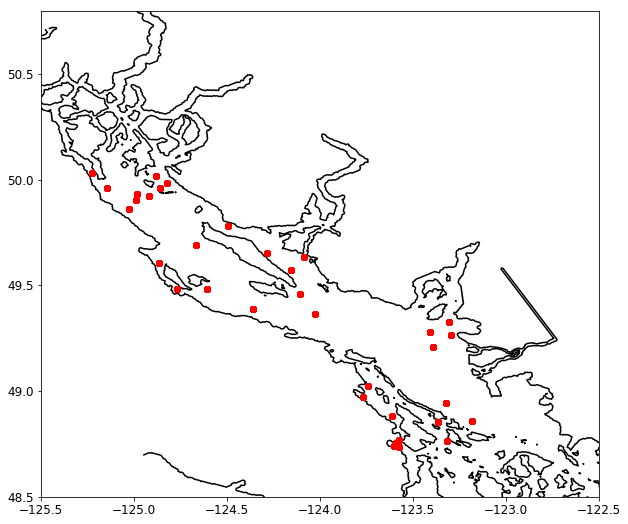

In [23]:
fig, ax = plt.subplots(figsize = (10,10))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(list_of_lons, list_of_lats, 'ro')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48.5, 50.8)
ax.set_xlim(-125.5, -122.5);

In [24]:
list_of_cs_ni.shape

(1362,)

In [25]:
list_of_model_ni.shape

(1362,)

surface bias =  1.972148636208972
surface RMSE = 5.079674987161972
surface Willmott = 0.8529159894333944
20m bias =  5.685960980319743
20m RMSE = 8.185276734948225
20m Willmott = 0.5543790964868649
bias =  3.826328073797317
RMSE = 6.809602055704631
Willmott = 0.8036878933959636


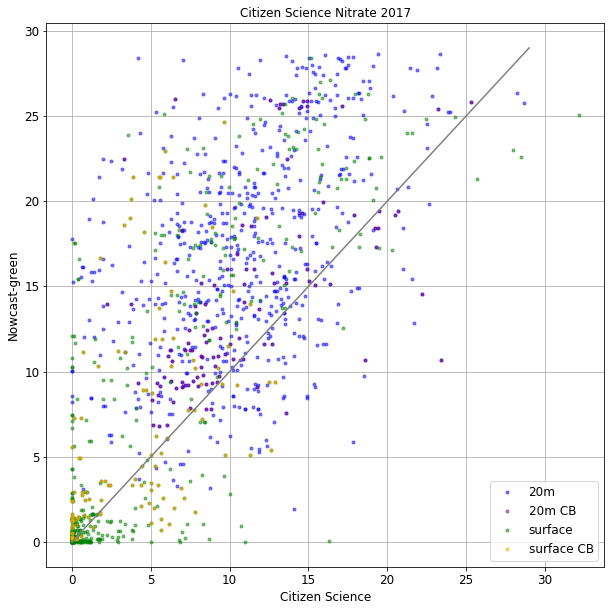

In [26]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(list_of_cs_ni[list_of_depths == 18], list_of_model_ni[list_of_depths == 18],  
        'b.', alpha = 0.5, label = '20m')
ax.plot(cb_cs_ni[cb_depths == 18], cb_model_ni[cb_depths == 18],  
        '.', color = 'purple', alpha = 0.5, label = '20m CB')
ax.plot(list_of_cs_ni[list_of_depths == 0], list_of_model_ni[list_of_depths==0],  
        'g.', alpha = 0.5, label = 'surface')
ax.plot(cb_cs_ni[cb_depths == 0], cb_model_ni[cb_depths == 0],  
        '.', color = 'orange', alpha = 0.5, label = 'surface CB')
ax.plot(np.arange(0,30), color = 'grey')
ax.grid('on')
ax.set_title('Citizen Science Nitrate 2017')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
ax.legend()
print('surface bias =  ' + str(-np.mean(list_of_cs_ni[list_of_depths == 0]) 
                               + np.mean(list_of_model_ni[list_of_depths == 0])))
print('surface RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni[list_of_depths == 0] 
                                              - list_of_cs_ni[list_of_depths == 0])**2) /
                              len(list_of_cs_ni[list_of_depths == 0]))))
xbar = np.mean(list_of_cs_ni[list_of_depths == 0])
print('surface Willmott = ' + str(1-(np.sum((list_of_model_ni[list_of_depths == 0] 
                                             - list_of_cs_ni[list_of_depths == 0])**2)  / 
                             np.sum((np.abs(list_of_model_ni[list_of_depths == 0] - xbar) 
                                     + np.abs(list_of_cs_ni[list_of_depths == 0] - xbar))**2))))

print('20m bias =  ' + str(-np.mean(list_of_cs_ni[list_of_depths == 18]) 
                               + np.mean(list_of_model_ni[list_of_depths == 18])))
print('20m RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni[list_of_depths == 18] 
                                              - list_of_cs_ni[list_of_depths == 18])**2) /
                              len(list_of_cs_ni[list_of_depths == 18]))))
xbar = np.mean(list_of_cs_ni[list_of_depths == 18])
print('20m Willmott = ' + str(1-(np.sum((list_of_model_ni[list_of_depths == 18] 
                                             - list_of_cs_ni[list_of_depths == 18])**2)  / 
                             np.sum((np.abs(list_of_model_ni[list_of_depths == 18] - xbar) 
                                     + np.abs(list_of_cs_ni[list_of_depths == 18] - xbar))**2))))

print('bias =  ' + str(-np.mean(list_of_cs_ni) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - list_of_cs_ni)**2) /
                              len(list_of_cs_ni))))
xbar = np.mean(list_of_cs_ni)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - list_of_cs_ni)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(list_of_cs_ni - xbar))**2))))

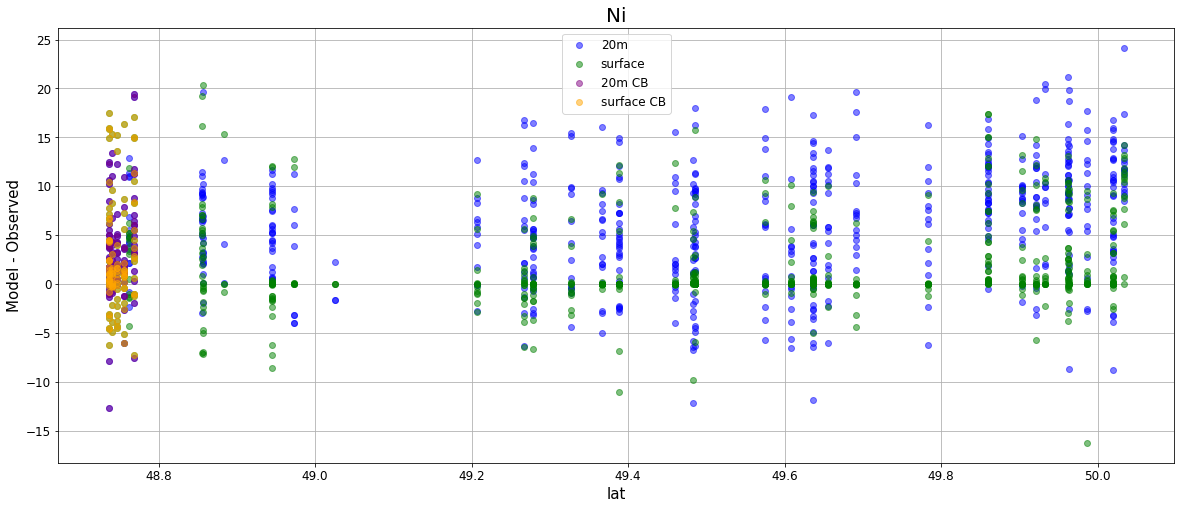

In [27]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lats[list_of_depths == 18], 
        list_of_model_ni[list_of_depths == 18] 
        - list_of_cs_ni[list_of_depths == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_lats[list_of_depths == 0], 
        list_of_model_ni[list_of_depths == 0] 
        - list_of_cs_ni[list_of_depths == 0], 'go', alpha =0.5, label = 'surface')
ax.plot(cb_lats[cb_depths == 18], 
        cb_model_ni[cb_depths == 18] 
        - cb_cs_ni[cb_depths == 18], 'o', color = 'purple', alpha =0.5, label = '20m CB')
ax.plot(cb_lats[cb_depths == 0], 
        cb_model_ni[cb_depths == 0] 
        - cb_cs_ni[cb_depths == 0], 'o', color = 'orange', alpha =0.5, label = 'surface CB')
ax.legend()
ax.grid('on')
ax.set_xlabel('lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Ni', fontsize = 20);

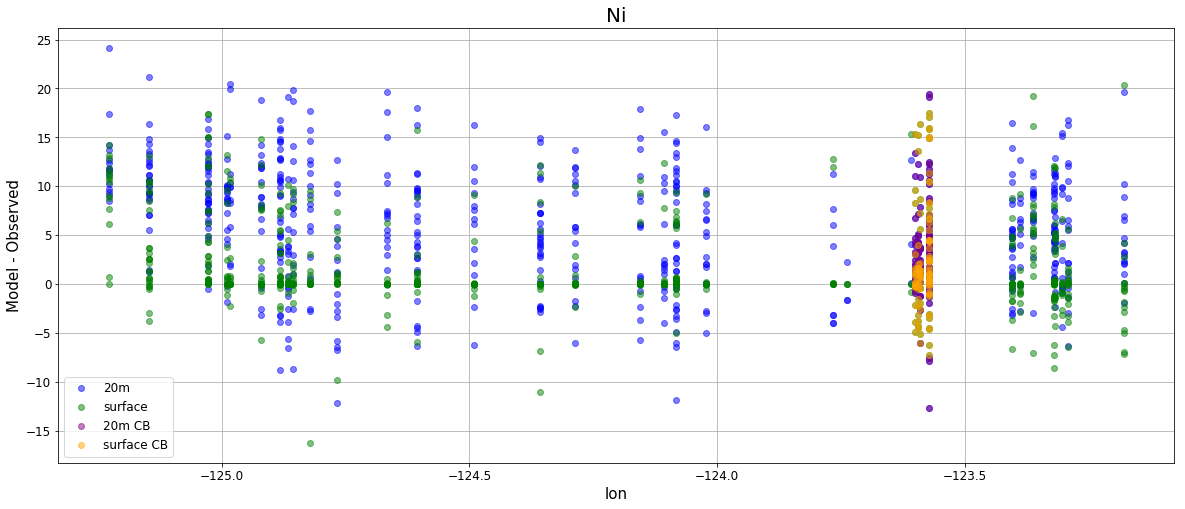

In [28]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lons[list_of_depths == 18], 
        list_of_model_ni[list_of_depths == 18] 
        - list_of_cs_ni[list_of_depths == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_lons[list_of_depths == 0], 
        list_of_model_ni[list_of_depths == 0] 
        - list_of_cs_ni[list_of_depths == 0], 'go', alpha =0.5, label = 'surface')
ax.plot(cb_lons[cb_depths == 18], 
        cb_model_ni[cb_depths == 18] 
        - cb_cs_ni[cb_depths == 18], 'o', color = 'purple', alpha =0.5, label = '20m CB')
ax.plot(cb_lons[cb_depths == 0], 
        cb_model_ni[cb_depths == 0] 
        - cb_cs_ni[cb_depths == 0], 'o', color = 'orange', alpha =0.5, label = 'surface CB')
ax.legend()
ax.grid('on')
ax.set_xlabel('lon', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Ni', fontsize = 20);

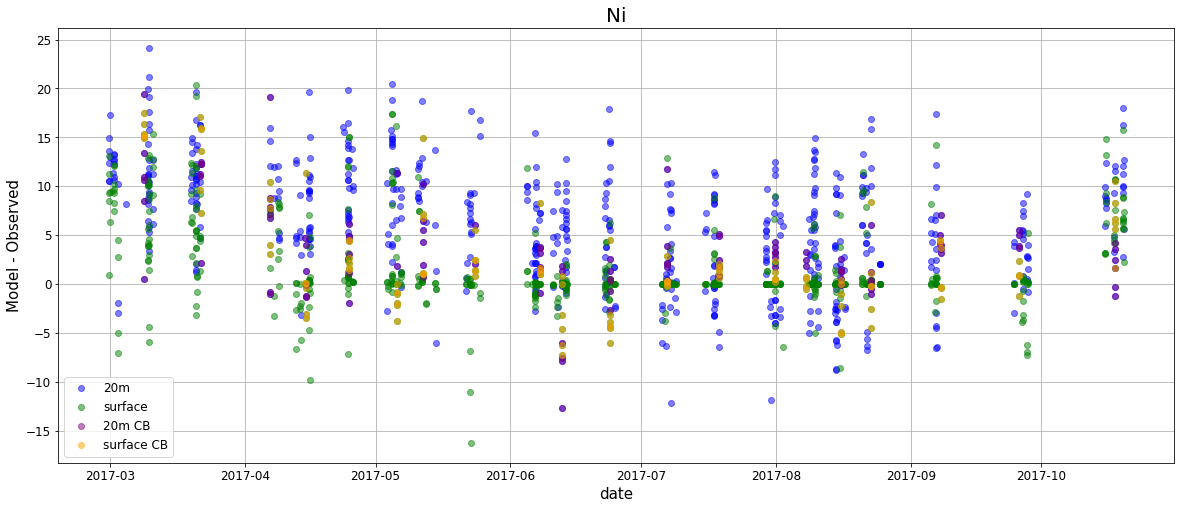

In [29]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_datetimes[list_of_depths == 18], 
        list_of_model_ni[list_of_depths == 18] 
        - list_of_cs_ni[list_of_depths == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_datetimes[list_of_depths == 0], 
        list_of_model_ni[list_of_depths == 0] 
        - list_of_cs_ni[list_of_depths == 0], 'go', alpha =0.5, label = 'surface')
ax.plot(cb_datetimes[cb_depths == 18], 
        cb_model_ni[cb_depths == 18] 
        - cb_cs_ni[cb_depths == 18], 'o', color = 'purple', alpha =0.5, label = '20m CB')
ax.plot(cb_datetimes[cb_depths == 0], 
        cb_model_ni[cb_depths == 0] 
        - cb_cs_ni[cb_depths == 0], 'o', color = 'orange', alpha =0.5, label = 'surface CB')
ax.legend()
ax.grid('on')
ax.set_xlabel('date', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Ni', fontsize = 20);

In [30]:
import matplotlib.patches as patches

In [31]:
list_of_depths.shape

(1362,)

In [32]:
list_of_cs_si.shape

(1362,)

surface bias =  -11.233163140372604
surface RMSE = 18.62607696470656
surface Willmott = 0.6575801331935687
20m bias =  -14.610193377659911
20m RMSE = 21.509919484632416
20m Willmott = 0.46435325747306433
bias =  -12.919198794818545
RMSE = 20.117621811856242
Willmott = 0.642173919928779


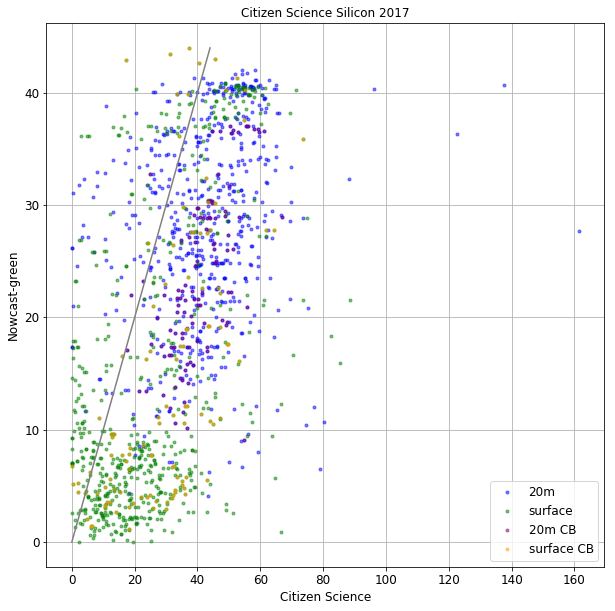

In [34]:
fig, ax = plt.subplots(figsize = ((10,10)))
ax.plot(list_of_cs_si[list_of_depths == 18], list_of_model_si[list_of_depths == 18],  
        'b.', alpha = 0.5, label = '20m')
ax.plot(list_of_cs_si[list_of_depths == 0], list_of_model_si[list_of_depths==0],  
        'g.', alpha = 0.5, label = 'surface')
ax.plot(cb_cs_si[cb_depths == 18], cb_model_si[cb_depths == 18],  
        '.', color = 'purple', alpha = 0.5, label = '20m CB')
ax.plot(cb_cs_si[cb_depths == 0], cb_model_si[cb_depths == 0],  
        '.', color = 'orange', alpha = 0.5, label = 'surface CB')
ax.plot(np.arange(0,45), color = 'grey')
ax.grid('on')
ax.set_title('Citizen Science Silicon 2017')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
ax.legend()
print('surface bias =  ' + str(-np.mean(list_of_cs_si[list_of_depths == 0]) 
                               + np.mean(list_of_model_si[list_of_depths == 0])))
print('surface RMSE = ' + str(np.sqrt(np.sum((list_of_model_si[list_of_depths == 0] 
                                              - list_of_cs_si[list_of_depths == 0])**2) /
                              len(list_of_cs_si[list_of_depths == 0]))))
xbar = np.mean(list_of_cs_si[list_of_depths == 0])
print('surface Willmott = ' + str(1-(np.sum((list_of_model_si[list_of_depths == 0] 
                                             - list_of_cs_si[list_of_depths == 0])**2)  / 
                             np.sum((np.abs(list_of_model_si[list_of_depths == 0] - xbar) 
                                     + np.abs(list_of_cs_si[list_of_depths == 0] - xbar))**2))))

print('20m bias =  ' + str(-np.mean(list_of_cs_si[list_of_depths == 18]) 
                               + np.mean(list_of_model_si[list_of_depths == 18])))
print('20m RMSE = ' + str(np.sqrt(np.sum((list_of_model_si[list_of_depths == 18] 
                                              - list_of_cs_si[list_of_depths == 18])**2) /
                              len(list_of_cs_si[list_of_depths == 18]))))
xbar = np.mean(list_of_cs_si[list_of_depths == 18])
print('20m Willmott = ' + str(1-(np.sum((list_of_model_si[list_of_depths == 18] 
                                             - list_of_cs_si[list_of_depths == 18])**2)  / 
                             np.sum((np.abs(list_of_model_si[list_of_depths == 18] - xbar) 
                                     + np.abs(list_of_cs_si[list_of_depths == 18] - xbar))**2))))

print('bias =  ' + str(-np.mean(list_of_cs_si) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - list_of_cs_si)**2) /
                              len(list_of_cs_si))))
xbar = np.mean(list_of_cs_si)
print('Willmott = ' + str(1-(np.sum((list_of_model_si - list_of_cs_si)**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(list_of_cs_si - xbar))**2))))

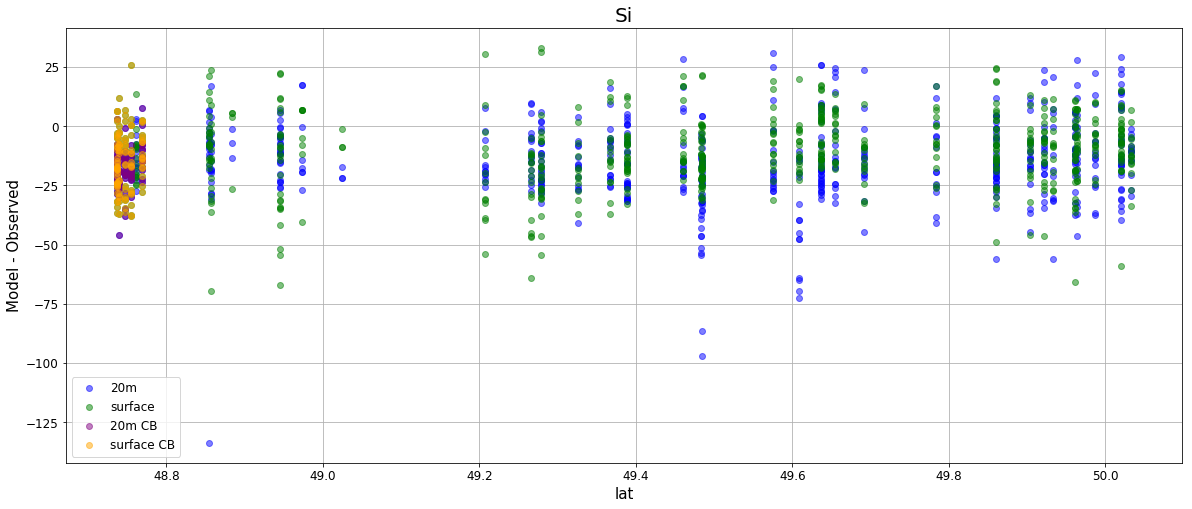

In [35]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lats[list_of_depths == 18], 
        list_of_model_si[list_of_depths == 18] 
        - list_of_cs_si[list_of_depths == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_lats[list_of_depths == 0], 
        list_of_model_si[list_of_depths == 0] 
        - list_of_cs_si[list_of_depths == 0], 'go', alpha =0.5, label = 'surface')
ax.plot(cb_lats[cb_depths == 18], 
        cb_model_si[cb_depths == 18] 
        - cb_cs_si[cb_depths == 18], 'o', color = 'purple', alpha =0.5, label = '20m CB')
ax.plot(cb_lats[cb_depths == 0], 
        cb_model_si[cb_depths == 0] 
        - cb_cs_si[cb_depths == 0], 'o', color = 'orange', alpha =0.5, label = 'surface CB')
ax.legend()
ax.grid('on')
ax.set_xlabel('lat', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Si', fontsize = 20);

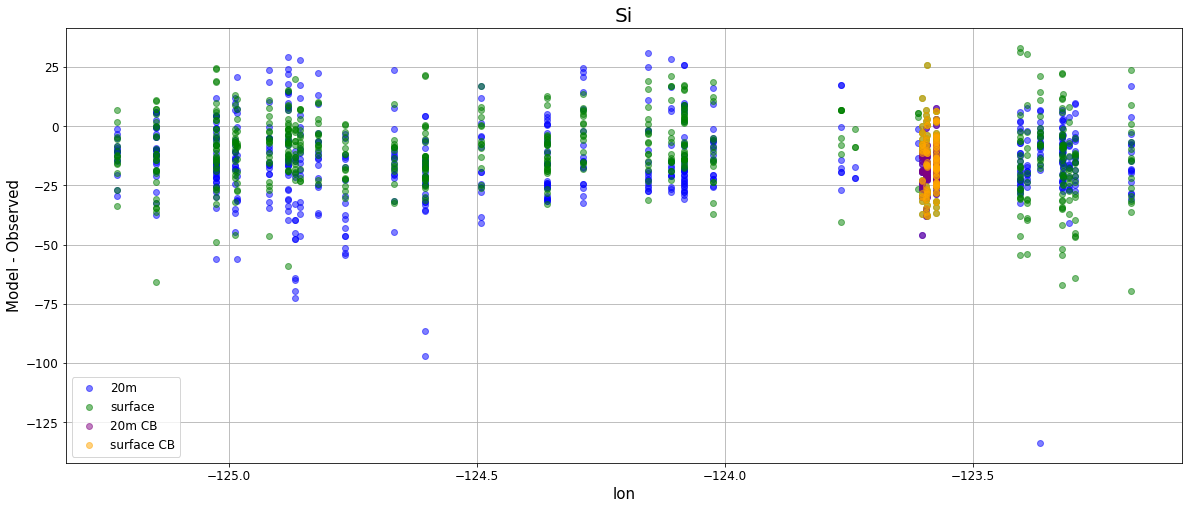

In [36]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_lons[list_of_depths == 18], 
        list_of_model_si[list_of_depths == 18] 
        - list_of_cs_si[list_of_depths == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_lons[list_of_depths == 0], 
        list_of_model_si[list_of_depths == 0] 
        - list_of_cs_si[list_of_depths == 0], 'go', alpha =0.5, label = 'surface')
ax.plot(cb_lons[cb_depths == 18], 
        cb_model_si[cb_depths == 18] 
        - cb_cs_si[cb_depths == 18], 'o', color = 'purple', alpha =0.5, label = '20m CB')
ax.plot(cb_lons[cb_depths == 0], 
        cb_model_si[cb_depths == 0] 
        - cb_cs_si[cb_depths == 0], 'o', color = 'orange', alpha =0.5, label = 'surface CB')
ax.legend()
ax.grid('on')
ax.set_xlabel('lon', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Si', fontsize = 20);

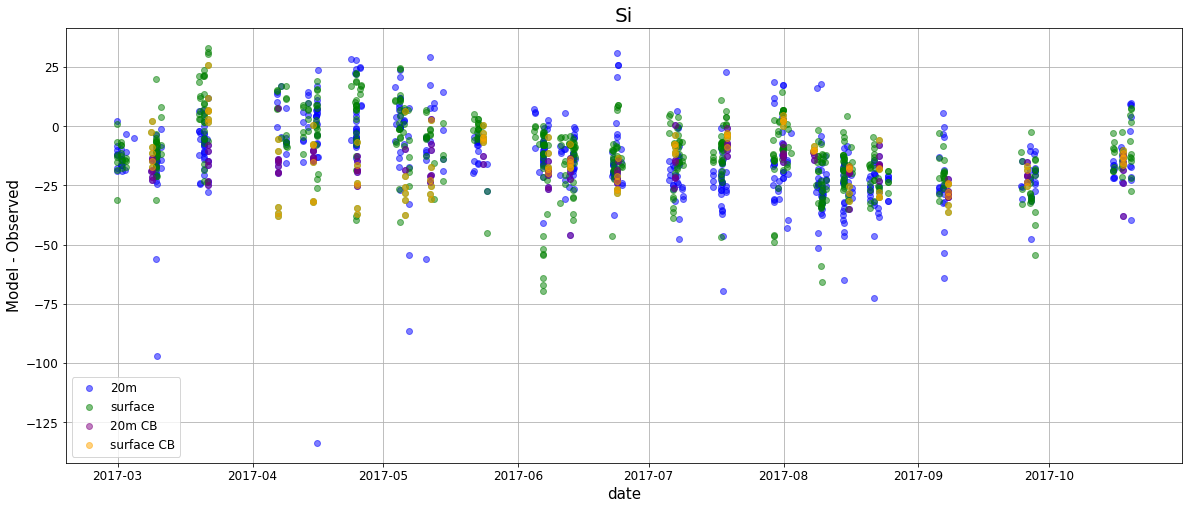

In [37]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(list_of_datetimes[list_of_depths == 18], 
        list_of_model_si[list_of_depths == 18] 
        - list_of_cs_si[list_of_depths == 18], 'bo', alpha =0.5, label = '20m')
ax.plot(list_of_datetimes[list_of_depths == 0], 
        list_of_model_si[list_of_depths == 0] 
        - list_of_cs_si[list_of_depths == 0], 'go', alpha =0.5, label = 'surface')
ax.plot(cb_datetimes[cb_depths == 18], 
        cb_model_si[cb_depths == 18] 
        - cb_cs_si[cb_depths == 18], 'o', color = 'purple', alpha =0.5, label = '20m CB')
ax.plot(cb_datetimes[cb_depths == 0], 
        cb_model_si[cb_depths == 0] 
        - cb_cs_si[cb_depths == 0], 'o', color = 'orange', alpha =0.5, label = 'surface CB')
ax.legend()
ax.grid('on')
ax.set_xlabel('date', fontsize = 15)
ax.set_ylabel('Model - Observed',fontsize = 15)
ax.set_title('Si', fontsize = 20);

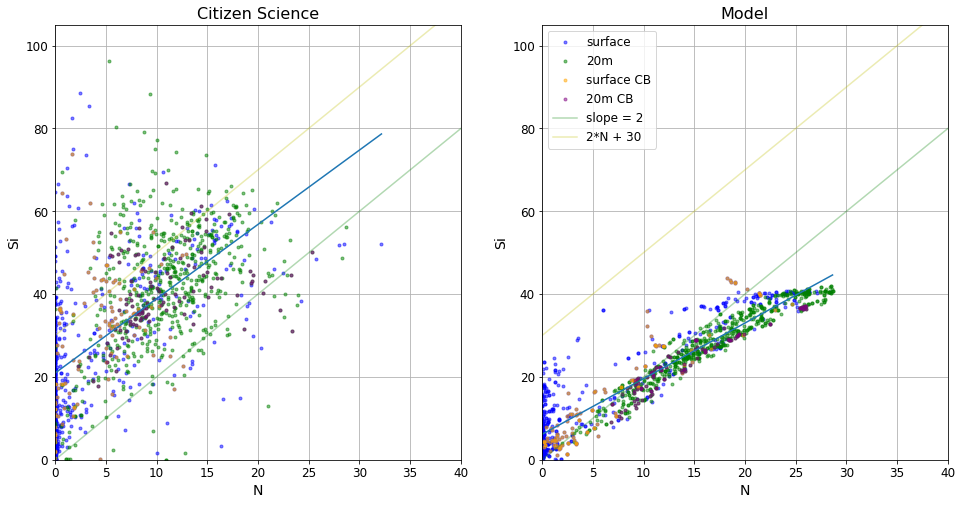

In [38]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].plot(list_of_cs_ni[list_of_depths == 0], list_of_cs_si[list_of_depths == 0], 
           'b.', alpha = 0.5)
ax[0].plot(list_of_cs_ni[list_of_depths == 18], list_of_cs_si[list_of_depths == 18], 
           'g.', alpha = 0.5)
ax[0].plot(cb_cs_ni[cb_depths == 0], cb_cs_si[cb_depths == 0], 
           '.', color = 'orange', alpha = 0.5)
ax[0].plot(cb_cs_ni[cb_depths == 18], cb_cs_si[cb_depths == 18], 
           '.', color = 'purple', alpha = 0.5)
ax[0].plot(np.unique(list_of_cs_ni), 
           np.poly1d(np.polyfit(list_of_cs_ni, list_of_cs_si, 1))(np.unique(list_of_cs_ni)))
x = np.arange(0,50)
#ax[0].plot(x,x, 'r-', alpha = 0.3)
ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[0].plot(x, 2*x+30, 'y-', alpha = 0.3)
ax[1].plot(list_of_model_ni[list_of_depths == 0], 
           list_of_model_si[list_of_depths == 0], 'b.', 
           alpha = 0.5, label = 'surface')
ax[1].plot(list_of_model_ni[list_of_depths == 18], 
           list_of_model_si[list_of_depths == 18], 'g.', 
           alpha = 0.5, label = '20m')
ax[1].plot(cb_model_ni[cb_depths == 0], cb_model_si[cb_depths == 0], 
           '.', color = 'orange', alpha = 0.5, label = 'surface CB')
ax[1].plot(cb_model_ni[cb_depths == 18], cb_model_si[cb_depths == 18], 
           '.', color = 'purple', alpha = 0.5, label = '20m CB')
ax[1].plot(np.unique(list_of_model_ni), 
           np.poly1d(np.polyfit(list_of_model_ni, 
                                list_of_model_si, 1))(np.unique(list_of_model_ni)))
x = np.arange(0,53)
#ax[1].plot(x,x, 'r-', alpha = 0.3, label = 'slope = 1')
ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[1].plot(x, 2*x+30, 'y-', alpha = 0.3, label = '2*N + 30')
ax[0].set_title('Citizen Science', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
    ax.set_ylim(0,105)
    ax.set_xlim(0,40)
plt.legend();

In [39]:
m1, b1 = np.polyfit(list_of_cs_ni, list_of_cs_si, 1)
print('CitSci slope = ' + str(m1))
print('CitSci y int = ' + str(b1))
m2, b2 = np.polyfit(list_of_model_ni, list_of_model_si, 1)
print('model slope = ' + str(m2))
print('model y int = ' + str(b2))

CitSci slope = 1.7947469023628777
CitSci y int = 20.939734016053333
model slope = 1.3439012783413538
model y int = 6.146051725781815


In [40]:
import pickle

In [41]:
output = open('model_si_2017.pkl', 'wb')
pickle.dump(list_of_model_si, output)
output.close()
output = open('model_ni_2017.pkl', 'wb')
pickle.dump(list_of_model_ni, output)
output.close()
output = open('cs_ni_2017.pkl', 'wb')
pickle.dump(list_of_cs_ni, output)
output.close()
output = open('cs_si_2017.pkl', 'wb')
pickle.dump(list_of_cs_si, output)
output.close()
output = open('cb_model_si_2017.pkl', 'wb')
pickle.dump(cb_model_si, output)
output.close()
output = open('cb_model_ni_2017.pkl', 'wb')
pickle.dump(cb_model_ni, output)
output.close()
output = open('cb_cs_ni_2017.pkl', 'wb')
pickle.dump(cb_cs_ni, output)
output.close()
output = open('cb_cs_si_2017.pkl', 'wb')
pickle.dump(cb_cs_si, output)
output.close()